# 1- El problema a resolver

Los físicos usan aceleradores de partículas, como el [Gran Colisionador de Hadrones](https://es.wikipedia.org/wiki/Gran_colisionador_de_hadrones) ubicado en la frontera entre Suiza y Francia, para descubrir nuevas partículas subatómicas.

La detección de estas partículas usualmente es un problema de clasificación, para determinar si el dato observado corresponde a la señal de interés o al ruido de fondo.

La idea es desarrollar un modelo de Deep Learning capaz de realizar esta clasificación.

# 2- El set de datos

El set de datos fue desarrollado por investigadores del Departamento de Física y Astronomía de la Universidad de California Irvine.

En total contiene 11 millones de datos, cada uno representado por 28 características (*features*):

- Las primeras 21 corresponden a propiedades cinemáticas medidas por los detectores de partículas en el acelerador.
- Las 7 características restantes son calculadas a partir de las 21 anteriores, y fueron derivadas por los físicos para facilitar el proceso de clasificación.

Cada dato está etiquetado en una de dos posibles características:

- "1": presencia de señal (posiblemente una partícula)
- "0": ruido de fondo (no corresponde a una partícula)

Para más información se sugiere mirar los detalles en el artículo [Searching for Exotic Particles in High-Energy Physics with Deep Learning](https://arxiv.org/pdf/1402.4735.pdf).

Teniendo en cuenta el elevado número de datos que contiene este set, para esta práctica se trabajará con una versión reducida del mismo (*HIGGS_subset.csv*) que contiene un total de 100.000 datos.

## 2.1- Preparación de lectura del set de datos

In [1]:
import pandas as pd

ruta = r'C:\Users\yordy\OneDrive\Escritorio\Internet Explorer\deep\learn\assets\datasets\HIGGS_subset.csv'
df = pd.read_csv(ruta)
print(df.shape)
df.head()

C:\Users\yordy\AppData\Local\Temp\ipykernel_12952\1779996405.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


(100000, 29)


,1.00E+00,8.69E-01,-6.35E-01,2.26E-01,3.27E-01,-6.90E-01,7.54E-01,-2.49E-01,-1.09E+00,0.00E+00,...,-1.05E-02,-4.58E-02,3.10E+00,1.35E+00,9.80E-01,9.78E-01,9.20E-01,7.22E-01,9.89E-01,8.77E-01
0,0,0.320083,-0.258156,-0.748752,0.934500,-0.007166,0.358276,-1.813136,-0.723959,0.000000,...,-0.505984,-1.425281,0.000000,0.823101,0.814655,0.988860,0.795775,0.650955,0.718191,0.642627
1,1,1.015883,-0.520153,-0.281001,0.624704,-0.784161,0.872192,-1.489331,1.576804,0.000000,...,1.254604,-0.800450,0.000000,0.367025,1.140837,0.986885,0.659926,0.921141,0.750046,0.719383
2,0,0.341129,-2.031753,0.731169,1.457364,-0.898847,0.175428,-1.724016,-1.037181,0.000000,...,0.224402,0.227907,3.101961,1.097289,0.871776,0.987942,0.869959,0.626679,1.114897,1.149453
3,0,0.812743,-1.324652,1.291579,0.468025,-0.063256,1.467181,-1.758674,-1.740129,0.000000,...,-0.030442,-1.218299,0.000000,0.883288,0.787425,0.986954,0.869872,0.562826,0.919145,0.789303
4,1,0.342410,1.051832,-1.309716,2.484316,-0.511491,0.704459,0.134646,1.313476,2.173076,...,-0.849108,-1.172796,1.550981,1.728419,1.202410,0.985475,1.203403,0.886029,0.903616,1.090524


In [2]:
# Distribución de categorías
df.iloc[:,0].value_counts()

1.00E+00
1    52892
0    47108
Name: count, dtype: int64

## 2.2- Creación del set de entrenamiento

In [3]:
X = df.values[:,1:]
Y = df.values[:,0]
print(X.shape)
print(Y.shape)

(100000, 28)
(100000,)


# 3- Creación y entrenamiento del modelo

- Capa de entrada: 28 elementos
- Capa de salida: 1 elemento (neurona de salida con activación sigmoidal)

Cuando no se tiene un referente previo se sugiere crear un primer modelo lo más simple posible. Crearemos un modelo con **una** capa oculta y el número de neuronas el promedio de las capas de entrada y de salida:

$n_{neuronas} = \frac{28+1}{2} = 15$

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import numpy as np
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DIM_ENTRADA = X.shape[1]   # 28
DIM_SALIDA = 1

modelo = Sequential()
modelo.add(Dense(15, activation='relu', input_shape=(DIM_ENTRADA,)))
modelo.add(Dense(DIM_SALIDA, activation='sigmoid'))

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                435       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


Verifiquemos el número de parámetros:

$ \text{Entrada a capa oculta: } 28x15 + 15 = 435$
$ \text{Capa oculta a salida: } 15x1 + 1 = 16$

In [5]:
# Compilación y entrenamiento
from tensorflow.keras.optimizers import Adam

EPOCHS = 1000
TAM_LOTE = 10000

opt = Adam()
modelo.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

historia = modelo.fit(X, Y, epochs=EPOCHS, batch_size = TAM_LOTE, verbose=1)

Epoch 1/1000
10/10 [==============================] - 2s 3ms/step - loss: 0.7267 - accuracy: 0.5171
Epoch 2/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5119
Epoch 3/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5187
Epoch 4/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5266
Epoch 5/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5302
Epoch 6/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5372
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.5433
Epoch 8/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.6863 - accuracy: 0.5504
Epoch 9/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5563
Epoch 10/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5623

# 4 - Resultados

In [6]:
import matplotlib.pyplot as plt

def graficar(historia):
  plt.figure(figsize=(15,5))

  loss = historia.history['loss']
  accuracy = historia.history['accuracy']
  epochs = historia.epoch

  plt.subplot(121)
  plt.plot(epochs,loss,label='train_loss')
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs,accuracy,label='train_acc')
  plt.legend()

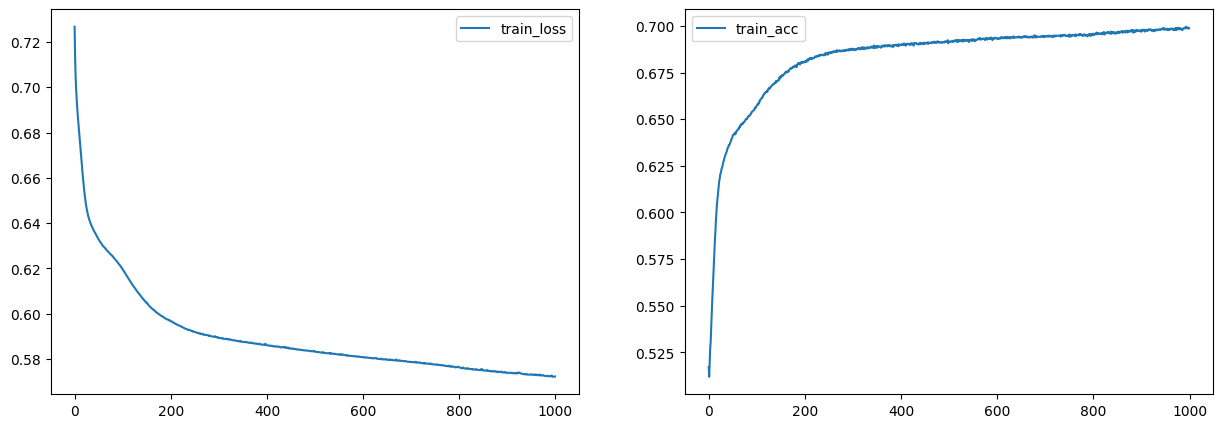

In [7]:
graficar(historia)

#5 - Sugerencias adicionales


Se pueden afinar diferentes hiperparámetros para intentar mejorar la precisión del modelo:

1. Cambiando el *número de neuronas* de la capa oculta
2. Agregando más capas y cambiando el número de neuronas de cada capa
3. Incrementando el *número de epochs*
4. Cambiando el *batch_size*
5. Modificando el *learning_rate* del optimizador (que por defecto está en 0.001)

#6 - Conclusión

Independientemente de los resultados que se obtengan, queda una pregunta de fondo por responder:

1. ¿Cómo saber si el modelo entrenado funcionará bien con nuevos datos?
2. ¿Cómo poder contar con una estrategia más confiable para estimar adecuadamente los hiperparámetros del modelo?